# 5.5-Signature of 41BB activation

Date of execution 

In [1]:
Sys.Date()

[1] "2025-04-14"

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)

suppressMessages(suppressWarnings({library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(stringr)
library(cowplot)
library(ggpubr)
library(UCell)
library(VennDiagram)
library(ComplexHeatmap)}))

## Parameters

In [3]:
source(here("utils/bin.R"))
source(here("utils/style.R"))

set.seed(0)

In [4]:
# depending on clone call
mode = "nt" 
chain = "TRB"

In [5]:
annot_tumor = list("0"="Pre-Exhausted CD8",
                    "1"="IFNG+ CD8",
                    "2"="Memory T-reg",
                    "3"="Exhausted CD8",
                    "4"="Effector Hobit CD8",
                    "5"="Naive T-reg",
                    "6"="T-helpers",
                    "7"="γδ T-cells",
                    "8"="Proliferative CD8",
                    "9_0"="Proliferative CD4",
                    "9_1"="Proliferative T-reg",
                    "10"="CXCL13+ CD8",
                    "11"="Naive CD4",
                    "12"="NKT",
                    "13"="FOXP3low T-reg")

## Load data

In [6]:
source(here("SCGRES_124_125/sc_analysis/misc/paths.R")) 
exp_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-ExpTCR_{mode}_{chain}.rds")))

In [7]:
source(here("SCGRES_83_120/misc/paths.R"))
tumor_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

In [8]:
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
markers_tumor <- read_csv(here(glue("{annot}/{robj_dir}/4.2-subset_tcell_only_1.csv")))

Rows: 12885 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): cluster, gene
dbl (5): p_val, avg_log2FC, pct.1, pct.2, p_val_adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Subset and merge only CD8

In [9]:
tumor_obj <- RenameIdents(object = tumor_obj, annot_tumor)
tumor_obj$annot <- Idents(tumor_obj)

In [10]:
names(tumor_pal) <- annot_tumor[names(tumor_pal)]

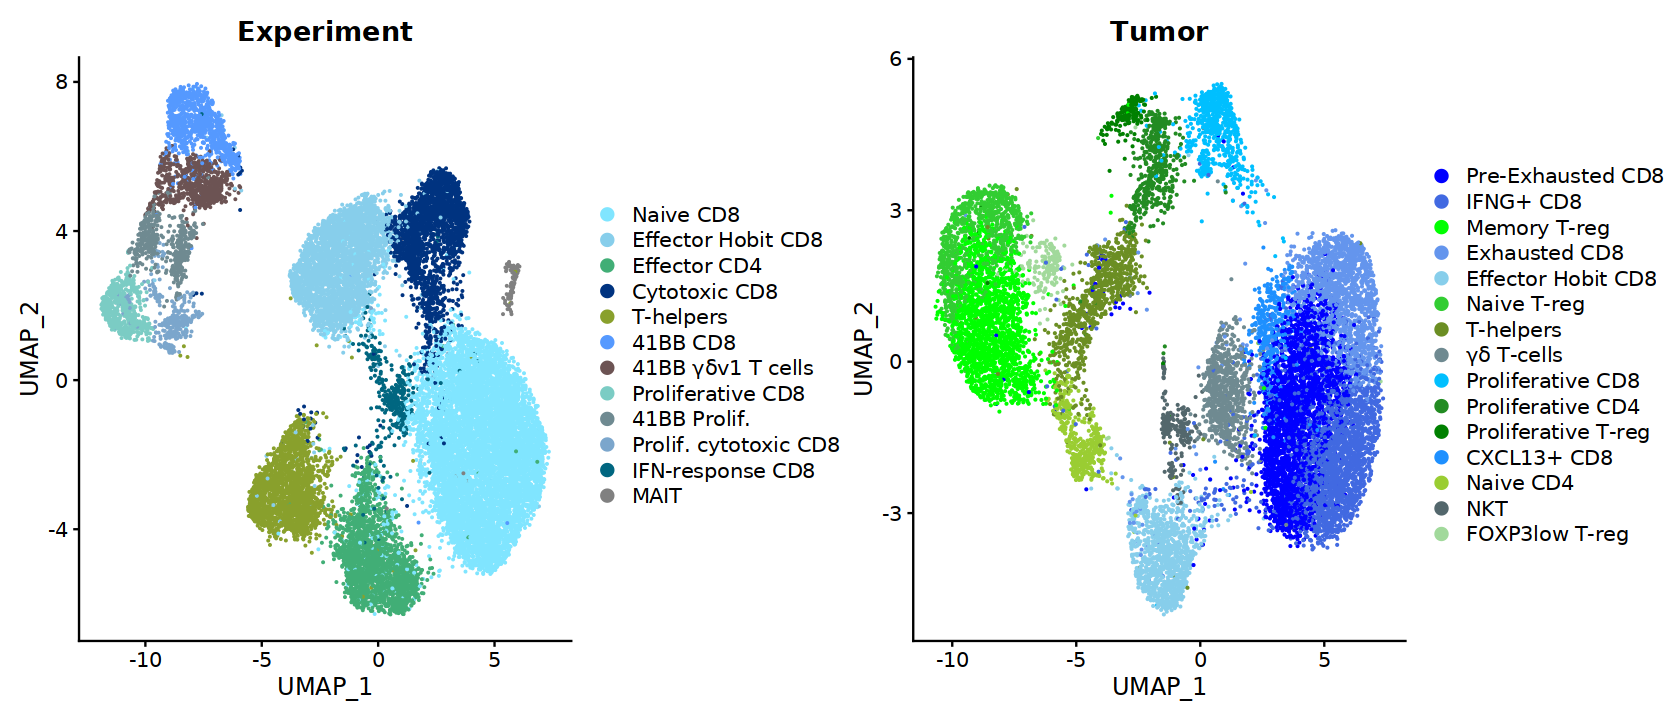

In [11]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
p_exp <- DimPlot(exp_obj, reduction = "umap", group.by = "annot",
                   label=F, cols=exp_pal)+ 
  labs(title=glue("Experiment"),
        label = T,
        label.box = TRUE,
        label.size = 3.5,
        repel = TRUE) + theme(plot.title = element_text(hjust = 0.5),
                                             legend.position = "right")
p_tumor <- DimPlot(tumor_obj, reduction = "umap",group.by = "annot", 
                   label=F, cols=tumor_pal)+ 
  labs(title=glue("Tumor"),
        label = T,
        label.box = TRUE,
        label.size = 3.5,
        repel = TRUE) + theme(plot.title = element_text(hjust = 0.5),
                                             legend.position = "right")
p_exp + p_tumor

In [12]:
cd8_exp <- c('Naive CD8','Effector Hobit CD8',
                                   'Cytotoxic CD8','41BB CD8',
                                   'Proliferative CD8','Prolif. cytotoxic CD8',
                                   'IFN-response CD8')
exp_obj <- subset(exp_obj, ident=cd8_exp)
exp_obj$annot <- factor(exp_obj$annot, levels = cd8_exp)

In [13]:
cd8_tumor <- c('Pre-Exhausted CD8','IFNG+ CD8',
               'Exhausted CD8','Effector Hobit CD8',
                'Proliferative CD8','CXCL13+ CD8')
tumor_obj <- subset(tumor_obj, ident=cd8_tumor)
tumor_obj$annot <- factor(tumor_obj$annot, levels = cd8_tumor)

In [14]:
tumor_obj@meta.data$annot <- as.character(tumor_obj@meta.data$annot)
exp_obj@meta.data$annot <- as.character(exp_obj@meta.data$annot)

Fix common annotation clusters

In [15]:
tumor_obj$source <- "Tumor T0"
exp_obj$source <- "Expansion exp."

tumor_obj$annot <- ifelse(tumor_obj$annot == "Proliferative CD8", paste(tumor_obj$annot, "T", sep = " "), tumor_obj$annot)
exp_obj$annot <- ifelse(exp_obj$annot == "Proliferative CD8", paste(exp_obj$annot, "E", sep = " "), exp_obj$annot)
tumor_obj$annot <- ifelse(tumor_obj$annot == "Effector Hobit CD8", paste(tumor_obj$annot, "T", sep = " "), tumor_obj$annot)
exp_obj$annot <- ifelse(exp_obj$annot == "Effector Hobit CD8", paste(exp_obj$annot, "E", sep = " "), exp_obj$annot)

In [16]:
names(tumor_pal) <- ifelse(names(tumor_pal) == "Proliferative CD8", paste(names(tumor_pal), "T", sep = " "), names(tumor_pal))
names(exp_pal) <- ifelse(names(exp_pal) == "Proliferative CD8", paste(names(exp_pal), "E", sep = " "), names(exp_pal))
names(tumor_pal) <- ifelse(names(tumor_pal) == "Effector Hobit CD8", paste(names(tumor_pal), "T", sep = " "), names(tumor_pal))
names(exp_pal) <- ifelse(names(exp_pal) == "Effector Hobit CD8", paste(names(exp_pal), "E", sep = " "), names(exp_pal))
custom_pal<-c(tumor_pal, exp_pal)

In [17]:
combined_obj <- merge(
  x = tumor_obj,
  y = exp_obj)

## Renormalize merged object

In [18]:
print(table(rowSums(as.matrix(combined_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(combined_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
combined_obj[['RNA']]@counts <- combined_obj[['RNA']]@counts[rownames(keep_genes), ]
combined_obj[['RNA']]@data <- combined_obj[['RNA']]@data[rownames(keep_genes), ]
combined_obj


FALSE  TRUE 
28288  1300 


An object of class Seurat 
28288 features across 24932 samples within 1 assay 
Active assay: RNA (28288 features, 0 variable features)

In [19]:
combined_obj <- combined_obj %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4) 

## Profile CD8 clusters according to 41BB+ cluster in experiment

In [20]:
source(here("SCGRES_124_125/sc_analysis/misc/paths.R")) 
markers_exp <- read_csv(here(glue("{annot}/{robj_dir}/4.0.1-Reclustering_Exp2.csv")))

New names:
• `` -> `...1`
Rows: 20929 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ...1, cluster, gene
dbl (5): p_val, avg_log2FC, pct.1, pct.2, p_val_adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
markers_pos <- markers_exp %>%
    dplyr::filter(cluster == "5_0") %>%
    dplyr::filter(p_val_adj <0.05 & avg_log2FC > 0.5) %>%
    arrange(desc(avg_log2FC))

Pseudo-bulk per cluster

In [22]:
list_objects <- SplitObject(combined_obj, split.by = "annot")
col_names <-  names(list_objects)

counts <- matrix(nrow=dim(list_objects[[1]]@assays$RNA@counts)[1], ncol=0)
lib_sizes <- c()

for (d in col_names){
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  c <- rowSums(m)
  counts <- cbind(counts, c)
  
  ls <- sum(colSums(m))
  lib_sizes <- c(lib_sizes, ls)
}
colnames(counts)<-col_names

logcpm <- counts
for (i in seq_along(names(list_objects))){
  ls <- lib_sizes[i]
  d <- colnames(logcpm)[i]
  logcpm[, d]<-log2((logcpm[, d]/ls*1e6)+1) 
}
## scaling between 0 and 1
mat1 <- t(apply(logcpm[head(markers_pos, n=70)$gene, ], 1, function(x) (x - min(x)) / diff(range(x))))

# sorting columns by 41BB
mat1 = mat1[, order(mat1["TNFRSF9", ])]
df_col <- data.frame(CD8_clusters=colnames(mat1))
row.names(df_col) <- colnames(mat1)

In [23]:
# top annotation data
source_data <- ifelse(colnames(mat1) %in% unique(combined_obj@meta.data[combined_obj$source == "Tumor T0",]$annot), 
                      "Tumor T0", "Expansion exp.")
source_colors <- c("Tumor T0"="#8c6bb1", "Expansion exp."="#ccccccff")

In [24]:
options(repr.plot.width = 6, repr.plot.height = 18, warn=-1,verbose = FALSE)
heatmap <- Heatmap(
  mat1,
  col = c('#FFFFFF','#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c',
          '#fc4e2a','#e31a1c','#bd0026','#800026'),
  name = "scaled mean\nexpression",
  cluster_columns = FALSE,
  cluster_rows = TRUE,
  show_row_names = TRUE,
  show_column_names = FALSE,
  column_title_gp = gpar(fontsize = 14, fontface = "bold"),
  row_names_gp = gpar(fontsize = 12),
  top_annotation = HeatmapAnnotation(
      text = anno_text(colnames(mat1), rot = 45,
                      offset = unit(2, "npc"),just = "left", 
                      height=unit(0.2, "cm")), 
      df = df_col, 
      col = list(CD8_clusters=custom_pal),
      show_annotation_name = FALSE,
      source = anno_simple(
          source_data, 
          col = source_colors, 
          width = unit(1, "cm"), 
  )),
 heatmap_legend_param = list(legend_direction = "horizontal", 
                                legend_width = unit(5, "cm"))
)
source(here("SCGRES_83_120/misc/paths.R"))
svg(here(glue("{annot}/{plt_dir}/5.5-41BB_markers_HC_heatmap.svg")),
   width = 6, height = 18)
draw(heatmap, merge_legend = TRUE, column_dend_side = "bottom",heatmap_legend_side = "bottom",
    padding = unit(c(10, 20, 50,15), "mm"))
dev.off()

png 
  2

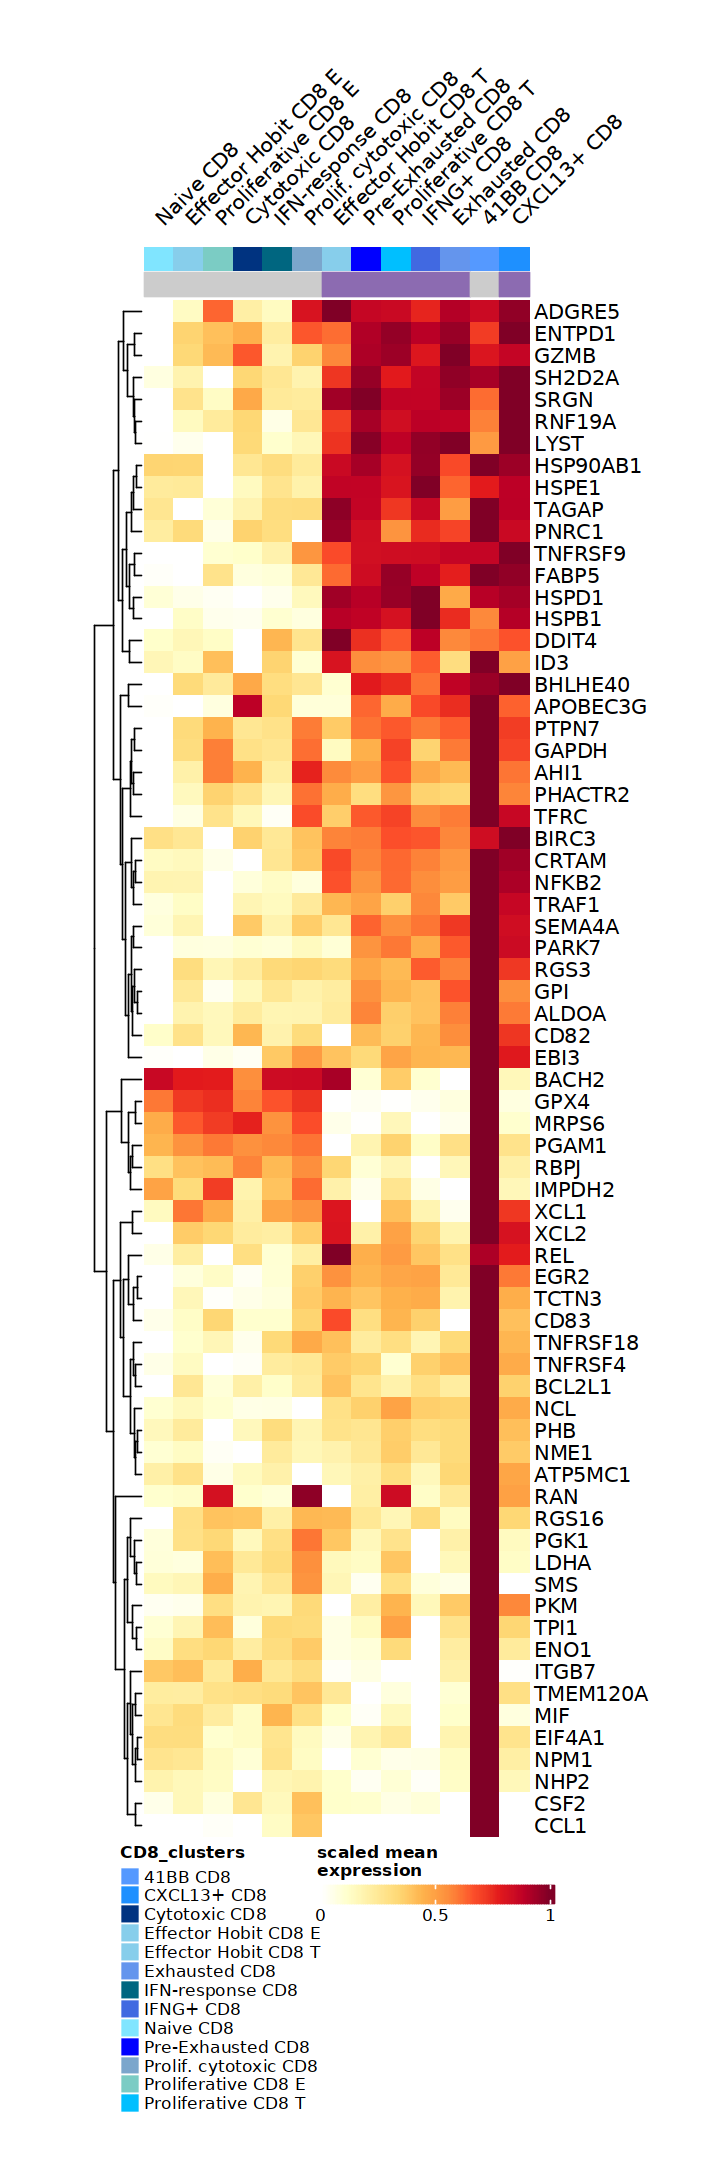

In [25]:
options(repr.plot.width = 6, repr.plot.height = 18, warn=-1,verbose = FALSE)
ht <- draw(heatmap, merge_legend = TRUE, column_dend_side = "bottom",heatmap_legend_side = "bottom",
    padding = unit(c(10, 20, 50,15), "mm"))

Similar top markers as in here
https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.02568/full#F4

In [26]:
markers = list()
markers[["CD8_41BB_profile"]] <- c(markers_pos$gene)

In [27]:
dim(markers_pos)

[1] 314   8

## Heatmap signature

In [28]:
source(here("SCGRES_83_120/misc/paths.R"))

In [29]:
# List of selected TCRs from 10x and OS-T data
df_list <- read.csv(here(glue("ext_data/selected/validated.csv")), sep='\t')

df_list$cdr3 <- substr(df_list$cdr3_nt_B, start = 3 + 1, stop = nchar(df_list$cdr3_nt_B)-3)
df_list <- df_list %>%
  mutate(Labels = na_if(Labels, ""))
df_list$identifier <- ifelse(is.na(df_list$Labels), df_list$Validation.code, paste(df_list$Validation.code, df_list$Labels, sep = "_"))

In [30]:
head(df_list)

,TCR_genes_A,cdr3_aa_A,cdr3_nt_A,TCR_genes_B,cdr3_aa_B,cdr3_nt_B,Validation.code,Labels,Origin,TCR_status,cdr3,identifier
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAV12-1.TRAJ41.TRAC,CVVRDKNSGYALNF,TGTGTGGTCCGCGATAAGAATTCCGGGTATGCACTCAACTTC,TRBV7-9.NA.TRBJ1-1.TRBC1,CASSQNSATGWTEAFF,TGTGCCAGCAGCCAAAACTCGGCGACAGGATGGACTGAAGCTTTCTTT,RP7-1/RP7-39,4,Blood-derived,,GCCAGCAGCCAAAACTCGGCGACAGGATGGACTGAAGCTTTC,RP7-1/RP7-39_4
2,TRAV8-4.TRAJ20.TRAC,CAVSTLNDYKLSF,TGTGCTGTGAGTACGCTTAACGACTACAAGCTCAGCTTT,TRBV11-2.NA.TRBJ2-2.TRBC2,CASSLEWYLGITGELFF,TGTGCCAGCAGCTTAGAGTGGTATTTGGGAATCACCGGGGAGCTGTTTTTT,RP7-10/RP7-48,I,Blood-derived,validated,GCCAGCAGCTTAGAGTGGTATTTGGGAATCACCGGGGAGCTGTTT,RP7-10/RP7-48_I
3,TRAV12-2.TRAJ29.TRAC,CAVPSGNTPLVF,TGTGCCGTTCCTTCAGGAAACACACCTCTTGTCTTT,TRBV5-5.NA.TRBJ1-2.TRBC1,CASSFKRQGGGYTF,TGTGCCAGCAGCTTCAAACGACAGGGTGGAGGCTACACCTTC,RP7-11/RP7-49,6,Blood-derived,,GCCAGCAGCTTCAAACGACAGGGTGGAGGCTACACC,RP7-11/RP7-49_6
4,TRAV21.TRAJ42.TRAC,CAVNYGGSQGNLIF,TGTGCCGTGAATTCTGGGGGTTACCAGAAAGTTACCTTT;TGTGCTGTGAATTATGGAGGAAGCCAAGGAAATCTCATCTTT,TRBV6-1.TRBD2.TRBJ2-5.TRBC2,CASRLAGGQETQYF,TGTGCCAGCAGACTAGCGGGGGGGCAAGAGACCCAGTACTTC,RP7-13/RP7-50,NA,Blood-derived,,GCCAGCAGACTAGCGGGGGGGCAAGAGACCCAGTAC,RP7-13/RP7-50
5,TRAV12-2.TRAJ43.TRAC,CAVNGYNNNDMRF,TGTGCCGTGAACGGGTACAATAACAATGACATGCGCTTT,TRBV5-4.NA.TRBJ2-1.TRBC2,CASSYKQGGEQFF,TGTGCCAGCAGCTATAAACAGGGAGGTGAGCAGTTCTTC,RP7-14/RP7-51,D,Blood-derived,,GCCAGCAGCTATAAACAGGGAGGTGAGCAGTTC,RP7-14/RP7-51_D
6,TRAV8-4.TRAJ43.TRAC,CAVILYNNNDMRF,TGTGCTGTGATCCTCTACAATAACAATGACATGCGCTTT,TRBV10-3.NA.TRBJ1-1.TRBC1,CAISESRLFTEAFF,TGTGCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTCTTT,RP7-15/RP7-52,NA,Blood-derived,,GCCATCAGTGAGTCTCGTCTGTTCACTGAAGCTTTC,RP7-15/RP7-52


In [31]:
## List of TCRs with high expansion levels before and after ICI in OS-T data
df_mem <- read.csv(here(glue("ext_data/selected/memory_selected.csv")))
df_mem <- df_mem %>% 
    dplyr::filter(nchar(cdr3) > 15)
df_mem$memory <- "memory"
write_csv(df_mem, here(glue("ext_data/selected/memory_selected_filt.csv")))

In [32]:
pbmc_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-pbmcTCR_{mode}_{chain}.rds")))
tumor_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

In [33]:
combined_obj <- merge(
  x = tumor_obj,
  y = pbmc_obj)

In [34]:
print(table(rowSums(as.matrix(combined_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(combined_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
combined_obj[['RNA']]@counts <- combined_obj[['RNA']]@counts[rownames(keep_genes), ]
combined_obj[['RNA']]@data <- combined_obj[['RNA']]@data[rownames(keep_genes), ]
combined_obj


FALSE 
29343 


An object of class Seurat 
29343 features across 36993 samples within 1 assay 
Active assay: RNA (29343 features, 0 variable features)

In [35]:
combined_obj <- combined_obj %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4) 

In [36]:
df_meta <- combined_obj@meta.data

In [37]:
## Add external info to metadata of combined obj
df_meta <- left_join(df_meta, df_list, 
                    by=join_by(CTnt==cdr3_nt_B, cdr3==cdr3))
df_meta <- df_meta %>%
    mutate(TCR_status = case_when(cdr3 %in% df_mem$cdr3 ~ "memory",
                                 TRUE ~ as.character(TCR_status))) %>%
    mutate(identifier = case_when(cdr3 %in% df_mem$cdr3 ~ "memory",
                                 TRUE ~ as.character(identifier)))
combined_obj@meta.data$identifier <- df_meta$identifier
combined_obj@meta.data$TCR_status <- df_meta$TCR_status

In [38]:
length(table(combined_obj@meta.data[combined_obj@meta.data$identifier == "memory", ]$cdr3))

[1] 16

In [39]:
color_ident <- c(
'RP7-20/RP7-43_Top 17'="#ffff99",    
'RP7-19/RP7-55_Top 3'="#a6cee3",
'RP7-23/RP7-58_Top 4'="#1f78b4",
'RP7-27/RP7-61_Top 7'="#fdbf6f",
'RP7-33/RP7-67_Top 6'="#33a02c",           
'RP7-35/RP7-69_Top 8'="#ff7f00",
'RP6-80/RP7-72_Top 1'="#e31a1c",
'RP6-81/RP7-38_Top 2'="#fb9a99",
'RP7-10/RP7-48_I'='#FF7F00',
'RP7-28/RP7-62_1'='#E78AC3',
'RP7-4/RP7-42'="#aa8800ff",
'RP7-17/RP7-41_Top 5'="#b2df8a",
'RP7-2/RP7-40_Top 10'="#6a3d9a",
'RP7-36/RP7-70_Top 9'="#cab2d6",
'RP7-17/RP7-41'="#b2df8a",
'RP7-1/RP7-39_4'= '#D95F02',               
'RP7-11/RP7-49_6'='#A6D854',
'RP7-14/RP7-51_D'='#4DAF4A',
'RP7-18/RP7-54_C'='#FC8D62',
'RP7-21/RP7-56_2'='#984EA3',
'RP7-22/RP7-57_B'='#E5C494',  
'RP7-29/RP7-63_A'='#A65628',
'RP7-30/RP7-64_5'='#66C2A5',             
'RP7-34/RP7-68_8'='#377EB8',
'RP7-37/RP7-71_7'='#8DA0CB',               
'RP7-7/RP7-45_9'='#E7298A',
'RP7-8/RP7-46_F'='#FFD92F',
'RP7-13/RP7-50'='#00FFFF',
'RP7-15/RP7-52'='#FFBF00',
'RP7-16/RP7-53'='#8B008B',
'RP7-24/RP7-59'='#39FF14',
'RP7-25/RP7-60'='#FF4500',
'RP7-6/RP7-44'='#87CEEB',
'memory'="#000000ff")               

### Using pseudo-bulks

Subset to selected TCRs

In [40]:
sub_obj <- subset(combined_obj, subset=identifier %in%names(table(combined_obj@meta.data$identifier)))

Based on this, we might need to remove some cases with few cells

In [41]:
table(sub_obj@meta.data[,c("identifier", "timepoint")])


                      timepoint
identifier              T0  T1  T2  T3  T4  T5  T6  T7
  memory                 0   6   5   7   2   1   9   3
  RP6-80/RP7-72_Top 1  177   0   0   0   0   0   0   0
  RP6-81/RP7-38_Top 2  116   0   0   0   0   0   0   0
  RP7-1/RP7-39_4         0   0  10   2   0   0   0   0
  RP7-10/RP7-48_I        0   0   2   0   0   0   0   0
  RP7-11/RP7-49_6        0   0  10   0   0   0   0   0
  RP7-13/RP7-50          0   0   0   1   1   0   1   0
  RP7-14/RP7-51_D        0   0   7   0   2   2   9   0
  RP7-15/RP7-52          3   0   0   2   0   0   0   0
  RP7-16/RP7-53          1   0   0   1   0   0   1   0
  RP7-17/RP7-41_Top 5   84   0   0   0   0   0   0   0
  RP7-18/RP7-54_C        0   0  24   1   1   1   7   1
  RP7-19/RP7-55_Top 3   90   0   0   0   0   0   0   0
  RP7-2/RP7-40_Top 10   59   0   0   0   0   0   0   0
  RP7-20/RP7-43_Top 17  44   0   0   0   0   0   0   0
  RP7-21/RP7-56_2        0   0  22   0   0   0   0   0
  RP7-22/RP7-57_B        0   0  4

In [42]:
sub_obj <- subset(sub_obj, subset=identifier %in% c("RP7-4/RP7-42","RP7-13/RP7-50",
                                                    "RP7-16/RP7-53", "RP7-25/RP7-60",
                                                    "RP7-6/RP7-44","RP7-7/RP7-45_9",
                                                    "RP7-8/RP7-46_F"), invert=T)

In [43]:
print(table(rowSums(as.matrix(sub_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(sub_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
sub_obj[['RNA']]@counts <- sub_obj[['RNA']]@counts[rownames(keep_genes), ]
sub_obj[['RNA']]@data <- sub_obj[['RNA']]@data[rownames(keep_genes), ]
sub_obj


FALSE  TRUE 
20096  9247 


An object of class Seurat 
20096 features across 1433 samples within 1 assay 
Active assay: RNA (20096 features, 0 variable features)

Create Groups of timepoints to increase cells per observation and gain robustness

In [44]:
df_sub <- sub_obj@meta.data

df_sub <- df_sub %>%
   mutate(Group = case_when(timepoint == "T0" ~ "T0",
                            timepoint == "T1" ~ "T1",
                            timepoint %in% c("T2", "T3") ~ "T2-3",
                            timepoint %in% c(paste0("T", c(4:7))) ~ "T4-7"))

In [45]:
table(df_sub[,c("identifier", "Group")])

                      Group
identifier              T0  T1 T2-3 T4-7
  memory                 0   6   12   15
  RP6-80/RP7-72_Top 1  177   0    0    0
  RP6-81/RP7-38_Top 2  116   0    0    0
  RP7-1/RP7-39_4         0   0   12    0
  RP7-10/RP7-48_I        0   0    2    0
  RP7-11/RP7-49_6        0   0   10    0
  RP7-14/RP7-51_D        0   0    7   13
  RP7-15/RP7-52          3   0    2    0
  RP7-17/RP7-41_Top 5   84   0    0    0
  RP7-18/RP7-54_C        0   0   25   10
  RP7-19/RP7-55_Top 3   90   0    0    0
  RP7-2/RP7-40_Top 10   59   0    0    0
  RP7-20/RP7-43_Top 17  44   0    0    0
  RP7-21/RP7-56_2        0   0   22    0
  RP7-22/RP7-57_B        0   0   45    0
  RP7-23/RP7-58_Top 4   88   0    0    0
  RP7-24/RP7-59          2   0    0    0
  RP7-27/RP7-61_Top 7   67   0    0    0
  RP7-28/RP7-62_1        0   0  145   70
  RP7-29/RP7-63_A        0   0   44    0
  RP7-30/RP7-64_5        0   0   22    0
  RP7-33/RP7-67_Top 6   84   0    0    0
  RP7-34/RP7-68_8        0   

In [46]:
df_sub$combined_var <- paste(df_sub$identifier, df_sub$Group, sep = ":")

In [47]:
sub_obj@meta.data$Group <- df_sub$Group
sub_obj@meta.data$combined_var <- df_sub$combined_var

Aggregate data of combined identifier and timepoint group

In [48]:
list_objects <- SplitObject(sub_obj, split.by = c("combined_var"))
col_names <-  names(list_objects)

counts <- matrix(nrow=dim(list_objects[[1]]@assays$RNA@counts)[1], ncol=0)
lib_sizes <- c()

for (d in col_names){
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  c <- rowSums(m)
  counts <- cbind(counts, c)
  
  ls <- sum(colSums(m))
  lib_sizes <- c(lib_sizes, ls)
}
colnames(counts)<-col_names

Create a new seurat object,normalize and then compute signature with UCell on pseudo-bulks

In [49]:
dim(df_sub)

[1] 1433   38

In [50]:
df_sub <- merge(df_sub, unique(df_list[,c("identifier", "Origin")]), by="identifier", all.x=TRUE)

In [51]:
df <- df_sub %>%
    rownames_to_column("rownames") %>%
    select(c("identifier", "TCR_status", "Group", "combined_var", "Origin")) %>%
    unique()
rownames(df)<- df$combined_var

In [52]:
seurat_obj <- CreateSeuratObject(counts=counts, project="pseudobulk", meta.data =df)

In [53]:
seurat_obj

An object of class Seurat 
20096 features across 33 samples within 1 assay 
Active assay: RNA (20096 features, 0 variable features)

In [54]:
seurat_obj <- seurat_obj %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4) 

In [55]:
seurat_obj <- AddModuleScore_UCell(seurat_obj, features = markers)
signature.names <- paste0(names(markers), "_UCell")

Prepare matrix for heatmap

In [56]:
mat <- seurat_obj@meta.data %>%
  select(c("Group", "identifier", "CD8_41BB_profile_UCell"))%>%
  arrange(Group) %>%
  tidyr::pivot_wider(names_from = identifier, values_from = CD8_41BB_profile_UCell)%>%
  column_to_rownames(var = "Group") %>% 
  as.matrix()

In [57]:
# Treat missing values as -Inf for sorting purposes
mat_for_sorting <- mat
mat_for_sorting[is.na(mat_for_sorting)] <- -Inf

# Exclude the "memory" column from sorting
memory_col <- which(colnames(mat) == "memory")
mat_to_sort <- mat[, -memory_col, drop = FALSE]

# Extract sorting keys
keys <- data.frame(T0 = mat_for_sorting["T0", -memory_col], T2_3 = mat_for_sorting["T2-3", -memory_col])

# Sort by T0 primarily and T2-3 secondarily
sorted_indices <- order(-keys$T0, -keys$T2_3, na.last = TRUE)

# Reorder columns (excluding "memory")
sorted_mat <- mat_to_sort[, sorted_indices]

# Append the "memory" column to the end
sorted_mat <- cbind(sorted_mat, memory = mat[, memory_col])

# View result
sorted_mat

,RP7-20/RP7-43_Top 17,RP7-33/RP7-67_Top 6,RP6-80/RP7-72_Top 1,RP7-19/RP7-55_Top 3,RP7-35/RP7-69_Top 8,RP7-17/RP7-41_Top 5,RP7-27/RP7-61_Top 7,RP7-23/RP7-58_Top 4,RP7-2/RP7-40_Top 10,RP6-81/RP7-38_Top 2,⋯,RP7-21/RP7-56_2,RP7-11/RP7-49_6,RP7-29/RP7-63_A,RP7-30/RP7-64_5,RP7-34/RP7-68_8,RP7-22/RP7-57_B,RP7-37/RP7-71_7,RP7-1/RP7-39_4,RP7-10/RP7-48_I,memory
T0,0.4759034,0.4351178,0.4308386,0.4291178,0.4276773,0.4257049,0.4231624,0.4228344,0.422242,0.4220764,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
T1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.3445945
T2-3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,0.4200403,0.4136444,0.4015255,0.3965807,0.3614809,0.3466072,0.3374161,0.3343376,0.3056221,0.3460531
T4-7,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,0.3377728,NA,NA,NA,NA,0.2991720


png 
  2

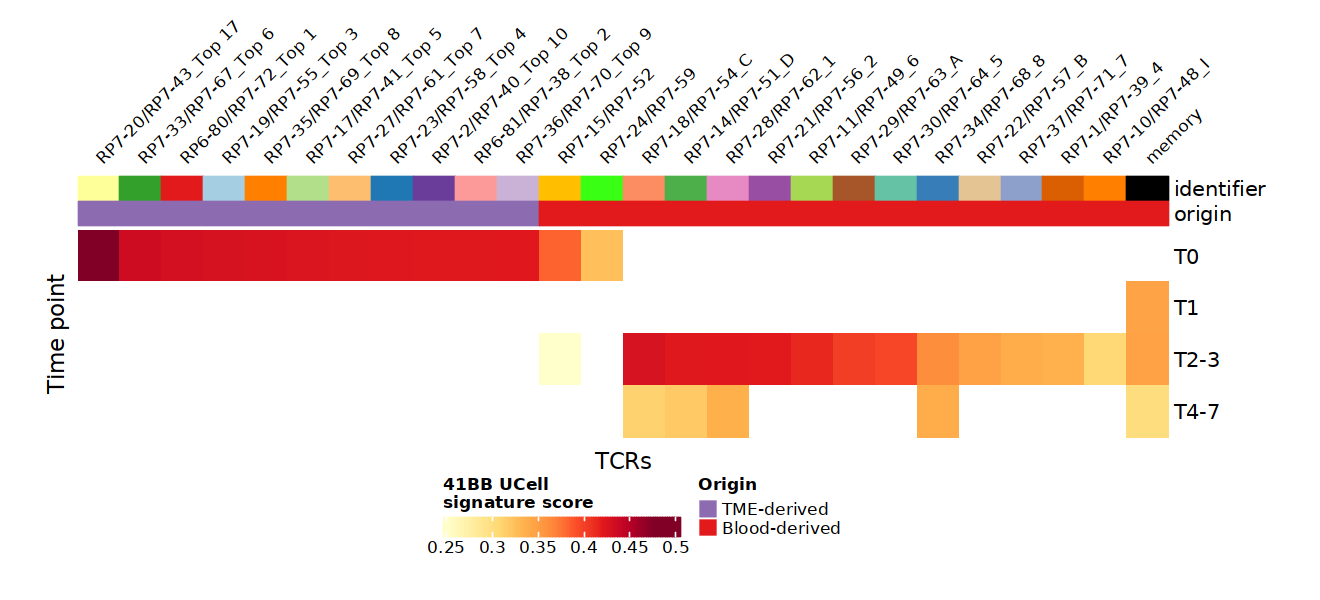

In [58]:
options(repr.plot.width = 11, repr.plot.height = 5, warn=-1,verbose = FALSE)

# Extra info on top
origin_data <- ifelse(colnames(sorted_mat) %in% df_list[df_list$Origin == "TME-derived",]$identifier, 
                      "TME-derived","Blood-derived")

origin_colors <- c("TME-derived" = "#8c6bb1", "Blood-derived" = "#e31a1c")


# Define top annotations
identifier_annotation <- HeatmapAnnotation(
  identifier_text = anno_text(
    colnames(sorted_mat),
    rot = 45, 
    just = "left", 
    gp = gpar(fontsize = 10), 
    height=unit(0.2, "cm")
  ),
  identifier = anno_simple(
    colnames(sorted_mat), 
    col = color_ident, 
    width = unit(0.2, "cm") 
  ),
  origin = anno_simple(
    origin_data, 
    col = origin_colors, 
    width = unit(1, "cm"), 
  )
)


heatmap <- Heatmap(
  sorted_mat,
  name = "41BB UCell\nsignature score",
  col = c('#ffffcc','#ffeda0','#fed976','#feb24c',
              '#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026'),
  na_col = "white", 
  top_annotation = identifier_annotation,
  cluster_rows = FALSE, 
  cluster_columns = FALSE, 
  show_row_names = TRUE,
  show_column_names = FALSE, 
  row_title = "Time point",
  column_title = "TCRs",
  column_title_side = "bottom",
  heatmap_legend_param = list(legend_direction = "horizontal", 
                                legend_width = unit(5, "cm"))
)

lgd_origin = Legend(
  title = "Origin",
  at = c("Blood-derived", "TME-derived"), 
  labels = names(origin_colors),    
  legend_gp = gpar(fill = origin_colors) 
)

source(here("SCGRES_83_120/misc/paths.R"))
svg(here(glue("{tcr}/{plt_dir}/5.5-TCRs_selected_signature_bulks.svg")),
   width = 11, height = 5)
draw(heatmap,padding = unit(c(10, 10, 35,15), "mm"),merge_legend = TRUE,
     column_dend_side = "right", heatmap_legend_side = "bottom",
     annotation_legend_list = list(lgd_origin))
dev.off()

# Draw the heatmap
draw(heatmap,padding = unit(c(10, 10, 35,15), "mm"),merge_legend = TRUE,
     column_dend_side = "right", heatmap_legend_side = "bottom",
     annotation_legend_list = list(lgd_origin))

## Comparing with published signatures

- Lowery et al 2022 (Table S8 CD8 NeoTCR)
- Caushi et al 2021
- Oliveria et al 2021

In [59]:
source(here("utils/variables.R"))

In [60]:
seurat_obj <- AddModuleScore_UCell(seurat_obj, features = public_signatures)
signature.names <- paste0(names(public_signatures), "_UCell")

In [61]:
plot_corr_sig <- function(df, x, y, c, colors, title) {
    
    # Extract info title
    split_by_newline <- strsplit(title, "\n")[[1]][2]
    labs <- strsplit(split_by_newline, "vs.")[[1]]
    
    # Calculate the correlation
    correlation <- cor.test(df[[x]], df[[y]], method = "pearson")
    r_squared <- correlation$estimate
    p_value <- correlation$p.value 
  
    # Make scatter plot
    p <- ggplot(df, aes_string(x = x, y = y, color = c)) +
      geom_point(size=3) +
      scale_color_manual(values = colors) +
      geom_smooth(method = "lm", se = TRUE, color = "black") +
      annotate("text", x = min(df[[x]])+0.2, y = max(df[[y]])+0.1, label = paste("r =", round(r_squared, 2), 
                                                       "\nP-value =", format.pval(p_value, digits = 2)), 
              hjust = 1.1, vjust = 1.1, size = 5, lineheight = 0.8) +
      labs(title = "",
           x = labs[1],
           y = labs[2],
           color = c) +
      theme_minimal(base_size = 18) +
      theme(plot.title = element_text(hjust = 0.5, size=18, margin = margin(b = 20))) 
    return(p)
}

In [62]:
p1 <- plot_corr_sig(seurat_obj@meta.data, "CD8_41BB_profile_UCell", "lowery_2022_UCell", 
             "identifier", color_ident, 
                    "Correlation of Signatures\nCD8 41BB profile vs. Lowery et al., 2022")

In [63]:
p2 <- plot_corr_sig(seurat_obj@meta.data, "CD8_41BB_profile_UCell", "caushi_2021_UCell", 
             "identifier", color_ident, 
                    "Correlation of Signatures\nCD8 41BB profile vs. Caushi et al., 2021")

In [64]:
p3 <- plot_corr_sig(seurat_obj@meta.data, "CD8_41BB_profile_UCell", "oliveira_2021_UCell", 
             "identifier", color_ident, 
                    "Correlation of Signatures\nCD8 41BB profile vs. Oliveira et al., 2021")

In [65]:
# Extract the legend from one of the plots
legend <- get_legend(p1)

# Remove the legends from the original plots
p1 <- p1 + theme(legend.position = "none")
p2 <- p2 + theme(legend.position = "none")
p3 <- p3 + theme(legend.position = "none")

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


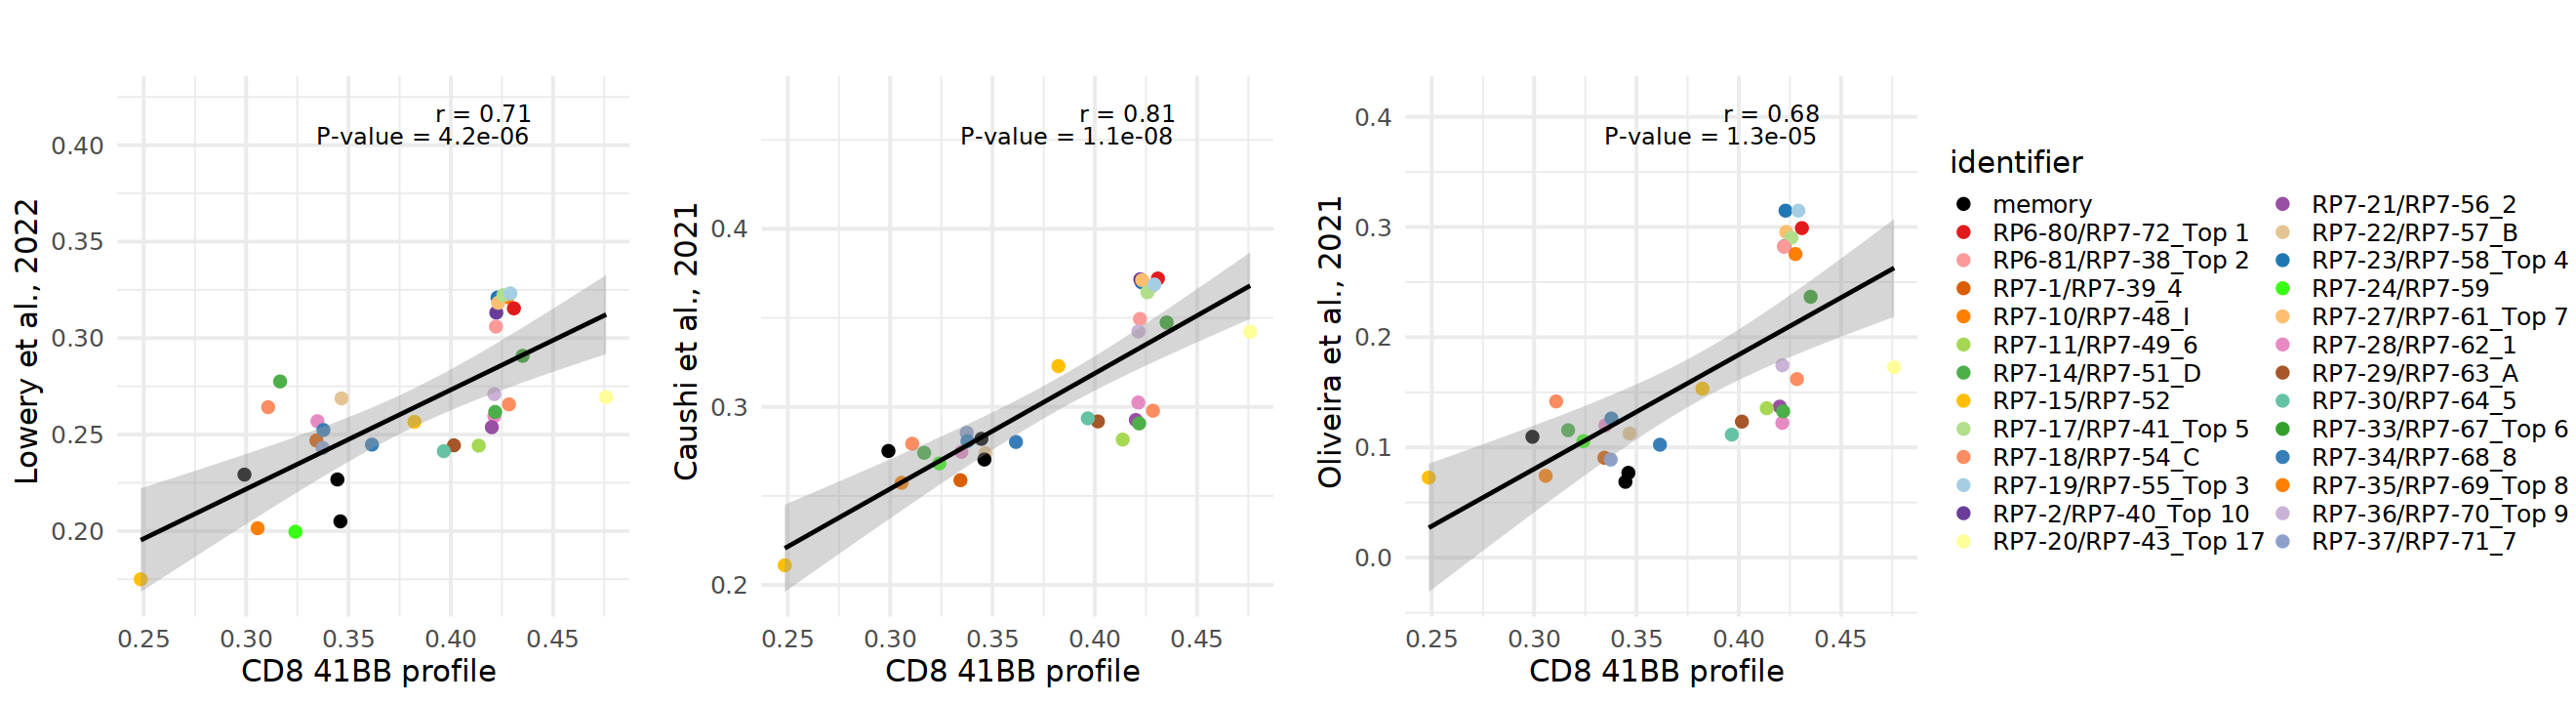

In [66]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(p1, p2, p3,legend,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 1)
cp

In [67]:
save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.5-Correlation_public_sig_identifier.svg")),
          base_width=24, base_height=6)

In [68]:
save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.5-Correlation_public_sig_identifier.png")),
          base_width=24, base_height=6)

# Session Info

In [69]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=es_ES.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=es_ES.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=es_ES.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ComplexHeatmap_2.10.0 VennDiagram_1.7.3     futile.logger_1.4.3  
 [4] UCell_1.3.1           ggpubr_0.6.0          cowplot_1.1.1        
 [7] lubridate_1.9.3       forcats_1.0.0         stringr_1.5.0        
[10] dplyr_1.1.3           purrr_1.0.2           readr